In [11]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip

URL transformed to HTTPS due to an HSTS policy
--2025-04-28 15:08:37--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip.2’

tiny-imagenet-200.z 100%[===================>] 236.61M  7.88MB/s    in 36s     

2025-04-28 15:09:13 (6.59 MB/s) - ‘tiny-imagenet-200.zip.2’ saved [248100043/248100043]



In [12]:
!unzip /content/tiny-imagenet-200.zip

Archive:  /content/tiny-imagenet-200.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/tiny-imagenet-200.zip or
        /content/tiny-imagenet-200.zip.zip, and cannot find /content/tiny-imagenet-200.zip.ZIP, period.


In [5]:
# %matplotlib inline
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
# from keras.engine.topology import Network
#from tensorflow.keras.models import Model, Network # Import Network from tensorflow.keras.models - This line is causing the issue. Removing Network as it is not part of tensorflow.keras.models
from tensorflow.keras.models import Model # Import only Model
from tensorflow.keras.utils import plot_model       # Import plot_model if needed
from keras.layers import *
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt

import numpy as np
import os
import random
import scipy.misc
from tqdm import *

%matplotlib inline

In [6]:
### Constants ###
DATA_DIR = "./tiny-imagenet-200"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SHAPE = (64, 64)


In [7]:
def load_dataset_small(num_images_per_class_train=10, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """
    X_train = []
    X_test = []

    # Create training set.
    for c in os.listdir(TRAIN_DIR):
        c_dir = os.path.join(TRAIN_DIR, c, 'images')
        c_imgs = os.listdir(c_dir)
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)

    # Create test set.
    test_dir = os.path.join(TEST_DIR, 'images')
    test_imgs = os.listdir(test_dir)
    random.shuffle(test_imgs)
    for img_name_i in test_imgs[0:num_images_test]:
        img_i = image.load_img(os.path.join(test_dir, img_name_i))
        x = image.img_to_array(img_i)
        X_test.append(x)

    # Return train and test data as numpy arrays.
    return np.array(X_train), np.array(X_test)


In [8]:
# Load dataset.
X_train_orig, X_test_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

FileNotFoundError: [Errno 2] No such file or directory: './tiny-imagenet-200/train'

In [20]:
# First half is used for training as secret images, second half for cover images.

# S: secret image
input_S = X_train[0:X_train.shape[0] // 2]

# C: cover image
input_C = X_train[X_train.shape[0] // 2:]

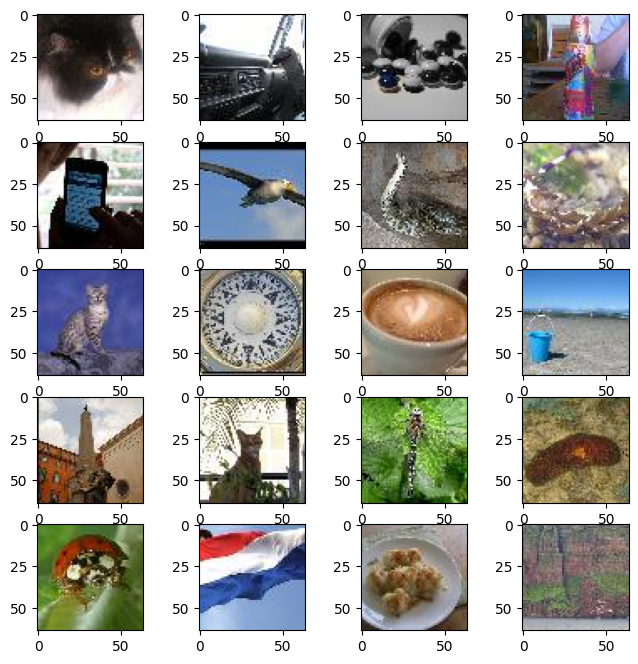

In [40]:

# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [29]:
beta = 1.0
import tensorflow as tf
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    # return beta * K.sum(K.square(s_true - s_pred))
    return beta * tf.reduce_sum(tf.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s_true, c_true = y_true[...,0:3], y_true[...,3:6]
    s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]

    s_loss = rev_loss(s_true, s_pred)
    # c_loss = K.sum(K.square(c_true - c_pred))
    c_loss = tf.reduce_sum(tf.square(c_true - c_pred))

    return s_loss + c_loss


# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3')(input_S)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4')(input_S)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5')(input_S)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x = concatenate([input_C, x])

    # Hiding network
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)

    return Model(inputs=[input_S, input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder(input_size, fixed=False):

    # Reveal network
    reveal_input = Input(shape=(input_size))

    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise')(reveal_input)

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])

    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])

    output_Sprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S')(x)

    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_Sprime,
                     name = 'Decoder')
    else:
        return Network(inputs=reveal_input,
                         outputs=output_Sprime,
                         name = 'DecoderFixed')

# Full model.
def make_model(input_size):
    input_S = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    encoder = make_encoder(input_size)

    decoder = make_decoder(input_size)
    decoder.compile(optimizer='adam', loss=rev_loss)
    decoder.trainable = False

    output_Cprime = encoder([input_S, input_C])
    output_Sprime = decoder(output_Cprime)

    autoencoder = Model(inputs=[input_S, input_C],
                        outputs=concatenate([output_Sprime, output_Cprime]))
    autoencoder.compile(optimizer='adam', loss=full_loss)

    return encoder, decoder, autoencoder


In [30]:
encoder_model, reveal_model, autoencoder_model = make_model(input_S.shape[1:])


In [31]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [32]:
NB_EPOCHS = 200
BATCH_SIZE = 32


m = input_S.shape[0]
loss_history = []
for epoch in range(NB_EPOCHS):
    np.random.shuffle(input_S)
    np.random.shuffle(input_C)

    t = tqdm(range(0, input_S.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss_list = []
    rev_loss_list = []
    for idx in t:

        batch_S = input_S[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]

        C_prime = encoder_model.predict([batch_S, batch_C])

        ae_loss_list.append(autoencoder_model.train_on_batch(x=[batch_S, batch_C],
                                                   y=np.concatenate((batch_S, batch_C),axis=3)))
        rev_loss_list.append(reveal_model.train_on_batch(x=C_prime,
                                              y=batch_S))

        # Update learning rate
        # K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        # K.set_value(reveal_model.optimizer.lr, lr_schedule(epoch))
        autoencoder_model.optimizer.learning_rate.assign(lr_schedule(epoch))
        reveal_model.optimizer.learning_rate.assign(lr_schedule(epoch))

        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f}'.format(epoch + 1, idx, m, np.mean( ae_loss_list), np.mean(rev_loss_list)))
    loss_history.append(np.mean(ae_loss_list))

  0%|          | 0/32 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
Epoch 1 | Batch:   0 of 1000. Loss AE  216236.81 | Loss Rev  108143.27:   3%|▎         | 1/32 [00:17<08:53, 17.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


Epoch 1 | Batch:  32 of 1000. Loss AE  205609.80 | Loss Rev  109501.36:   6%|▋         | 2/32 [00:17<03:39,  7.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 1 | Batch:  64 of 1000. Loss AE  200685.80 | Loss Rev  109274.65:   9%|▉         | 3/32 [00:17<01:59,  4.12s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch:  96 of 1000. Loss AE  193396.36 | Loss Rev  107725.97:  12%|█▎        | 4/32 [00:18<01:13,  2.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 1 | Batch: 128 of 1000. Loss AE  186941.98 | Loss Rev  106414.88:  16%|█▌        | 5/32 [00:18<00:48,  1.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 160 of 1000. Loss AE  181240.64 | Loss Rev  105211.55:  19%|█▉        | 6/32 [00:18<00:33,  1.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 192 of 1000. Loss AE  176800.89 | Loss Rev  104426.01:  22%|██▏       | 7/32 [00:19<00:24,  1.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 224 of 1000. Loss AE  172778.81 | Loss Rev  103632.88:  25%|██▌       | 8/32 [00:19<00:18,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 256 of 1000. Loss AE  169246.77 | Loss Rev  102962.80:  28%|██▊       | 9/32 [00:19<00:14,  1.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


Epoch 1 | Batch: 288 of 1000. Loss AE  166222.28 | Loss Rev  102533.02:  31%|███▏      | 10/32 [00:20<00:11,  1.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 320 of 1000. Loss AE  163550.34 | Loss Rev  102197.59:  34%|███▍      | 11/32 [00:20<00:09,  2.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 352 of 1000. Loss AE  161111.41 | Loss Rev  101868.32:  38%|███▊      | 12/32 [00:20<00:08,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 1 | Batch: 384 of 1000. Loss AE  158824.64 | Loss Rev  101507.03:  41%|████      | 13/32 [00:20<00:07,  2.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 416 of 1000. Loss AE  156744.25 | Loss Rev  101195.04:  44%|████▍     | 14/32 [00:21<00:06,  2.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 1 | Batch: 448 of 1000. Loss AE  154843.64 | Loss Rev  100921.18:  47%|████▋     | 15/32 [00:21<00:05,  2.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 480 of 1000. Loss AE  153103.69 | Loss Rev  100681.05:  50%|█████     | 16/32 [00:21<00:05,  2.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 1 | Batch: 512 of 1000. Loss AE  151487.91 | Loss Rev  100452.69:  53%|█████▎    | 17/32 [00:22<00:04,  3.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 544 of 1000. Loss AE  149990.62 | Loss Rev  100245.29:  56%|█████▋    | 18/32 [00:22<00:04,  3.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 576 of 1000. Loss AE  148616.88 | Loss Rev  100072.39:  59%|█████▉    | 19/32 [00:22<00:04,  3.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 608 of 1000. Loss AE  147331.94 | Loss Rev   99914.20:  62%|██████▎   | 20/32 [00:23<00:03,  3.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


Epoch 1 | Batch: 640 of 1000. Loss AE  146122.36 | Loss Rev   99762.61:  66%|██████▌   | 21/32 [00:23<00:03,  3.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 672 of 1000. Loss AE  144957.33 | Loss Rev   99595.40:  69%|██████▉   | 22/32 [00:23<00:03,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 1 | Batch: 704 of 1000. Loss AE  143895.67 | Loss Rev   99475.63:  72%|███████▏  | 23/32 [00:24<00:02,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 1 | Batch: 736 of 1000. Loss AE  142882.52 | Loss Rev   99351.54:  75%|███████▌  | 24/32 [00:24<00:02,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


Epoch 1 | Batch: 768 of 1000. Loss AE  141918.38 | Loss Rev   99230.34:  78%|███████▊  | 25/32 [00:24<00:02,  3.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 800 of 1000. Loss AE  141011.61 | Loss Rev   99122.24:  81%|████████▏ | 26/32 [00:24<00:01,  3.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 1 | Batch: 832 of 1000. Loss AE  140140.58 | Loss Rev   99009.46:  84%|████████▍ | 27/32 [00:25<00:01,  3.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 864 of 1000. Loss AE  139305.86 | Loss Rev   98896.05:  88%|████████▊ | 28/32 [00:25<00:01,  3.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


Epoch 1 | Batch: 896 of 1000. Loss AE  138515.64 | Loss Rev   98794.98:  91%|█████████ | 29/32 [00:25<00:00,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Epoch 1 | Batch: 928 of 1000. Loss AE  137755.56 | Loss Rev   98693.61:  94%|█████████▍| 30/32 [00:26<00:00,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


Epoch 1 | Batch: 960 of 1000. Loss AE  137024.19 | Loss Rev   98592.73:  97%|█████████▋| 31/32 [00:26<00:00,  3.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Epoch 1 | Batch: 960 of 1000. Loss AE  137024.19 | Loss Rev   98592.73:  97%|█████████▋| 31/32 [00:39<00:01,  1.28s/it]


KeyboardInterrupt: 

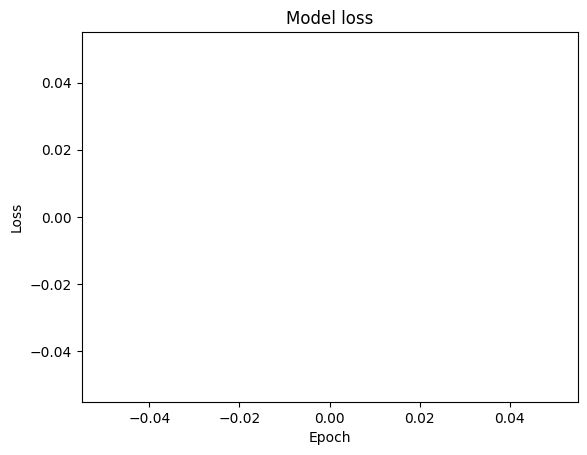

In [33]:
# Plot loss through epochs
plt.plot(loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [1]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S, input_C])
decoded_S, decoded_C = decoded[...,0:3], decoded[...,3:6]

# Get absolute difference between the outputs and the expected values.
diff_S, diff_C = np.abs(decoded_S - input_S), np.abs(decoded_C - input_C)

# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 1000) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 6 if SHOW_DIFF else 4
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret')

    show_image(decoded_C[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Encoded Cover')

    show_image(decoded_S[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Decoded Secret')


    if SHOW_DIFF:
        show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')

        show_image(np.multiply(diff_S[idx], ENHANCE), n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret')

plt.show()

NameError: name 'autoencoder_model' is not defined